In [1]:
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools
import pickle
%matplotlib inline

In [2]:
recalc=True #False

In [3]:
t0=dt.datetime(2015,1,1) # 
if recalc:
    with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
        tmask=np.copy(fm.variables['tmask'])
        umask=np.copy(fm.variables['umask'])
        vmask=np.copy(fm.variables['vmask'])
        navlon=np.copy(fm.variables['nav_lon'])
        navlat=np.copy(fm.variables['nav_lat'])
        e3t_0=np.copy(fm.variables['e3t_0'])
        e3u_0=np.copy(fm.variables['e3u_0'])
        e3v_0=np.copy(fm.variables['e3v_0'])
        e1t=np.copy(fm.variables['e1t'])
        e2t=np.copy(fm.variables['e2t'])
        e1v=np.copy(fm.variables['e1v'])
        e2u=np.copy(fm.variables['e2u'])
        A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

    #te=dt.datetime(2016,12,1)# last start date of runfnum=18
    stm=np.shape(tmask)
    SiN=1.2
    nlen= 73 # 2 yrs210
    #nlen=58#100
    dlist=[t0+dt.timedelta(days=ii*10) for ii in range(0,nlen)]

    #sdir0='/results/SalishSea/nowcast-green/'
    sdir1='/data/sallen/results/MEOPAR/202007/202007F/'
    #sdir3='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_HCMZ/'

    tmaskC=np.copy(tmask)
    tmaskC[:,:,370:490,:12]=0
    tmaskC[:,:,887:,30:70]=0

In [4]:
if recalc:
    tlist=dlist
    SiGlobalTot=dict()
    SiTot=dict()
    BSiTot=dict()
    DiatTot=dict()
    changeSiGlobalTot=dict()
    for idir in (sdir1,):
        fformat1='%d%b%y/'
        if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
            fformatT='SalishSea_1d_*_ptrc_T_%Y%m%d-*.nc'
            fformatP='SalishSea_1d_*_ptrc_T_%Y%m%d-*.nc'
        #elif idir==sdir1:
        #    fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        #    fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
        elif idir.startswith('/data/sallen/results/MEOPAR/202007/'):
            fformatT='SalishSea_1d_????????_????????_ptrc_T_%Y%m%d-*.nc'
            fformatP='SalishSea_1d_????????_????????_carp_T_%Y%m%d-*.nc'
        else:
            raise Exception('Name Error')
        sumSi=np.zeros((len(tlist),stm[2],stm[3]))
        sumBSi=np.zeros((len(tlist),stm[2],stm[3]))
        sumDiat=np.zeros((len(tlist),stm[2],stm[3]))
        ind=-1
        for idt0 in tlist:
            ind=ind+1
            cdir=idt0.strftime(fformat1).lower()
            iffT=idt0.strftime(fformatT)
            iffP=idt0.strftime(fformatP)
            if idir.startswith('/data/') and not ('link' in idir): #eolson/MEOPAR/SS36runs/CedarRuns/
                sffT=idir+iffT
                sffP=idir+iffP
            elif idir.startswith('/results/') or idir.startswith('/results2/') or ('link' in idir):
                sffT=idir+cdir+iffT
                sffP=idir+cdir+iffP
            print(sffT)
            f=nc.Dataset(glob.glob(sffT)[0])
            fP=nc.Dataset(glob.glob(sffP)[0])
            #if idir==sdir0:
            #    e3t=np.expand_dims((1+fP.variables['sossheig'][0,:,:]/np.sum(e3t_0*tmask,1)),0)*e3t_0
            if idir==sdir1:
                e3t=fP.variables['e3t'][:2,:,:,:]
            Vol=A*e3t
            sumSi[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['silicon'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumBSi[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['biogenic_silicon'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumDiat[ind,:,:]=SiN*1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['diatoms'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            f.close()
            fP.close()
        SiGlobalTot[idir]=np.sum(np.sum(sumSi+sumBSi+sumDiat,2),1)
        SiTot[idir]=np.sum(np.sum(sumSi,2),1)
        BSiTot[idir]=np.sum(np.sum(sumBSi,2),1)
        DiatTot[idir]=np.sum(np.sum(sumDiat,2),1)
        changeSiGlobalTot[idir]=[SiGlobalTot[idir][ii+1]-SiGlobalTot[idir][ii] for ii in range(0,len(tlist)-1)]

/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150101-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150111-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150121-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150131-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150210-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150220-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150302-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150312-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150322-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150401-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishS

In [5]:
klim=20
if recalc:
    tlist=dlist
    BSiTotS=dict()
    DiatTotS=dict()
    for idir in (sdir1,):
        fformat1='%d%b%y/'
        if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
            fformatT='SalishSea_1d_*_ptrc_T_%Y%m%d-*.nc'
            fformatP='SalishSea_1d_*_ptrc_T_%Y%m%d-*.nc'
        #elif idir==sdir1:
        #    fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        #    fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
        elif idir.startswith('/data/sallen/results/MEOPAR/202007/'):
            fformatT='SalishSea_1d_????????_????????_ptrc_T_%Y%m%d-*.nc'
            fformatP='SalishSea_1d_????????_????????_carp_T_%Y%m%d-*.nc'
        else:
            raise Exception('Name Error')
        sumBSiS=np.zeros((len(tlist),stm[2],stm[3]))
        sumDiatS=np.zeros((len(tlist),stm[2],stm[3]))
        ind=-1
        for idt0 in tlist:
            ind=ind+1
            cdir=idt0.strftime(fformat1).lower()
            iffT=idt0.strftime(fformatT)
            iffP=idt0.strftime(fformatP)
            if idir.startswith('/data/') and not ('link' in idir): #eolson/MEOPAR/SS36runs/CedarRuns/
                sffT=idir+iffT
                sffP=idir+iffP
            elif idir.startswith('/results/') or idir.startswith('/results2/') or ('link' in idir):
                sffT=idir+cdir+iffT
                sffP=idir+cdir+iffP
            print(sffT)
            f=nc.Dataset(glob.glob(sffT)[0])
            fP=nc.Dataset(glob.glob(sffP)[0])
            #if idir==sdir0:
            #    e3t=np.expand_dims((1+fP.variables['sossheig'][0,:,:]/np.sum(e3t_0*tmask,1)),0)*e3t_0
            if idir==sdir1:
                e3t=fP.variables['e3t'][:2,:,:,:]
            Vol=A*e3t
            sumBSiS[ind,:,:]=1e-3*np.sum(tmaskC[0,:klim,:,:]*Vol[0,:klim,:,:]*f.variables['biogenic_silicon'][0,:klim,:,:],0) #mmol/m3*m3*10^-3=mol
            sumDiatS[ind,:,:]=SiN*1e-3*np.sum(tmaskC[0,:klim,:,:]*Vol[0,:klim,:,:]*f.variables['diatoms'][0,:klim,:,:],0) #mmol/m3*m3*10^-3=mol
            f.close()
            fP.close()
        BSiTotS[idir]=np.sum(np.sum(sumBSiS,2),1)
        DiatTotS[idir]=np.sum(np.sum(sumDiatS,2),1)

/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150101-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150111-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150121-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150131-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150210-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150220-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150302-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150312-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150322-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150401-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishS

In [6]:
#test=np.sum(np.sum((sumSi[-1,:,:]+np.sum(1e-3*7*tmaskC[0,:,:,:]*Vol[0,:,:,:],0))+sumBSi[-1,:,:]+sumDiat[-1,:,:],1),0)
#test2=np.sum(np.sum(sumSi[-1,:,:]+sumBSi[-1,:,:]+sumDiat[-1,:,:],1),0)

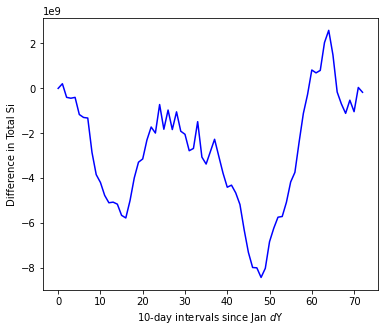

In [7]:
if recalc:
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    ax.plot(SiGlobalTot[sdir1]-SiGlobalTot[sdir1][0],'b-')
    ax.set_xlabel('10-day intervals since '+t0.strftime('%b $d $Y'))
    ax.set_ylabel('Difference in Total Si')

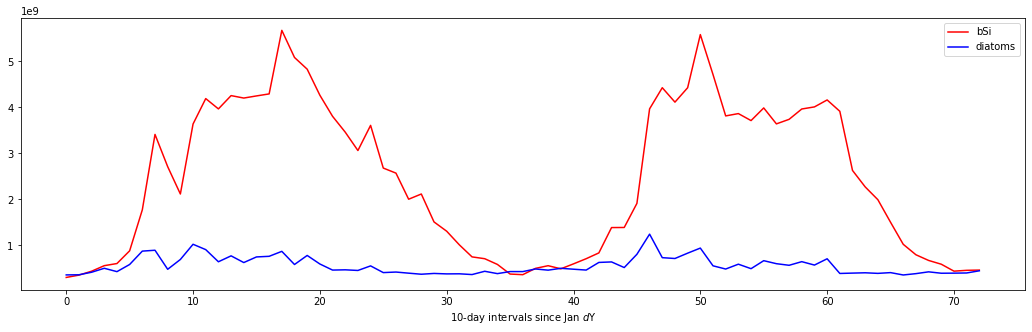

In [8]:
if recalc:
    ## plots related to sinking
    fig,ax=plt.subplots(1,1,figsize=(18,5))
    ax.plot(BSiTot[sdir1],'r-',label='bSi')
    ax.plot(DiatTot[sdir1],'b-',label='diatoms')
    ax.set_xlabel('10-day intervals since '+t0.strftime('%b $d $Y'))
    ax.legend()

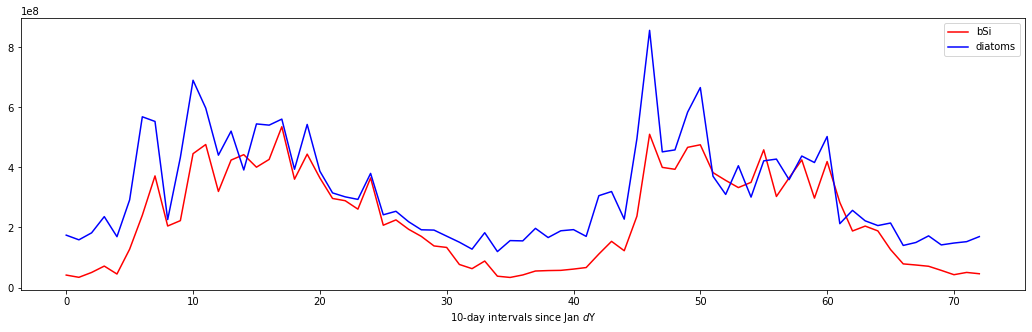

In [9]:
if recalc:
    ## plots related to sinking
    fig,ax=plt.subplots(1,1,figsize=(18,5))
    ax.plot(BSiTotS[sdir1],'r-',label='bSi')
    ax.plot(DiatTotS[sdir1],'b-',label='diatoms')
    ax.set_xlabel('10-day intervals since '+t0.strftime('%b $d $Y'))
    ax.legend()

std err total bsi is: 1627458027.1280026
  std err 20m bsi is: 154378932.65563294


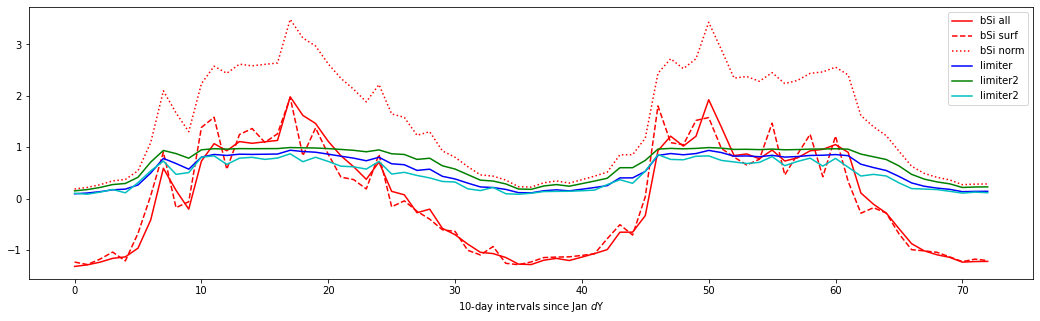

In [10]:
if recalc:
    fig,ax=plt.subplots(1,1,figsize=(18,5))
    ax.plot((BSiTot[sdir1]-np.mean(BSiTot[sdir1]))/np.std(BSiTot[sdir1]),'r-',label='bSi all')
    ax.plot((BSiTotS[sdir1]-np.mean(BSiTotS[sdir1]))/np.std(BSiTotS[sdir1]),'r--',label='bSi surf')
    ax.plot((BSiTot[sdir1])/np.std(BSiTot[sdir1]),'r:',label='bSi norm')
    ax.plot(np.tanh(.5*(BSiTot[sdir1])/np.std(BSiTot[sdir1])),'b-',label='limiter')
    ax.plot(np.tanh(.5*(BSiTot[sdir1])/1000000000),'g-',label='limiter2')
    ax.plot(np.tanh(.5*(BSiTotS[sdir1])/200000000),'c-',label='limiter2')
    ax.set_xlabel('10-day intervals since '+t0.strftime('%b $d $Y'))
    ax.legend()
    print('std err total bsi is:',np.std(BSiTot[sdir1]))
    print('  std err 20m bsi is:',np.std(BSiTotS[sdir1]))

In [11]:
# for bSi sinking rate, use:
# wmin+tanh(.5*bSi_20_sum/200000000)*(wmax-wmin)
# need to use cvol = e3t* e1t* e2t, so update code above...

In [12]:
# copy restart and add 7 to Si old and new

## repeat for N

In [13]:
if recalc:
    tlist=dlist
    NGlobalTot=dict()
    VolTot=dict()
    NO3Tot=dict()
    NH4Tot=dict()
    PONTot=dict()
    DONTot=dict()
    DiatTot=dict()
    MyriTot=dict()
    NanoTot=dict()
    MiZoTot=dict()
    changeNGlobalTot=dict()
    for idir in (sdir1,):
        fformat1='%d%b%y/'
        if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
            fformatT='SalishSea_1d_*_ptrc_T_%Y%m%d-*.nc'
            fformatP='SalishSea_1d_*_ptrc_T_%Y%m%d-*.nc'
        #elif idir==sdir1:
        #    fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        #    fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
        elif idir.startswith('/data/sallen/results/MEOPAR/202007/'):
            fformatT='SalishSea_1d_????????_????????_ptrc_T_%Y%m%d-*.nc'
            fformatP='SalishSea_1d_????????_????????_carp_T_%Y%m%d-*.nc'
        else:
            raise Exception('Name Error')
        sumNO3=np.zeros((len(tlist),stm[2],stm[3]))
        sumVol=np.zeros((len(tlist),stm[2],stm[3]))
        sumNH4=np.zeros((len(tlist),stm[2],stm[3]))
        sumPON=np.zeros((len(tlist),stm[2],stm[3]))
        sumDON=np.zeros((len(tlist),stm[2],stm[3]))
        sumDiat=np.zeros((len(tlist),stm[2],stm[3]))
        sumMyri=np.zeros((len(tlist),stm[2],stm[3]))
        sumNano=np.zeros((len(tlist),stm[2],stm[3]))
        sumMiZo=np.zeros((len(tlist),stm[2],stm[3]))
        ind=-1
        for idt0 in tlist:
            ind=ind+1
            cdir=idt0.strftime(fformat1).lower()
            iffT=idt0.strftime(fformatT)
            iffP=idt0.strftime(fformatP)
            if idir.startswith('/data/') and not ('link' in idir): #eolson/MEOPAR/SS36runs/CedarRuns/'):
                sffT=idir+iffT
                sffP=idir+iffP
            elif idir.startswith('/results/') or idir.startswith('/results2/') or ('link' in idir):
                sffT=idir+cdir+iffT
                sffP=idir+cdir+iffP
            print(sffT)
            f=nc.Dataset(glob.glob(sffT)[0])
            fP=nc.Dataset(glob.glob(sffP)[0])
            #if idir==sdir0:
            #    e3t=np.expand_dims((1+fP.variables['sossheig'][0,:,:]/np.sum(e3t_0*tmask,1)),0)*e3t_0
            if idir==sdir1:
                e3t=fP.variables['e3t'][:2,:,:,:]
            Vol=A*e3t
            sumVol[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumNO3[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['nitrate'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumNH4[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['ammonium'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumPON[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['particulate_organic_nitrogen'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumDON[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['dissolved_organic_nitrogen'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumDiat[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['diatoms'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumMyri[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['ciliates'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            sumMiZo[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['microzooplankton'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
            f.close()
            fP.close()
        NGlobalTot[idir]=np.sum(np.sum(sumNO3+sumNH4+sumPON+sumDON+sumDiat+sumMyri+sumNano+sumMiZo,2),1)
        VolTot[idir]=np.sum(np.sum(sumVol,2),1)
        NO3Tot[idir]=np.sum(np.sum(sumNO3,2),1)
        NH4Tot[idir]=np.sum(np.sum(sumNH4,2),1)
        PONTot[idir]=np.sum(np.sum(sumPON,2),1)
        DONTot[idir]=np.sum(np.sum(sumDON,2),1)
        DiatTot[idir]=np.sum(np.sum(sumDiat,2),1)
        MyriTot[idir]=np.sum(np.sum(sumMyri,2),1)
        NanoTot[idir]=np.sum(np.sum(sumNano,2),1)
        MiZoTot[idir]=np.sum(np.sum(sumMiZo,2),1)
        changeNGlobalTot[idir]=[NGlobalTot[idir][ii+1]-NGlobalTot[idir][ii] for ii in range(0,len(tlist)-1)]

/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150101-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150111-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150121-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150131-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150210-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150220-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150302-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150312-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150322-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishSea_1d_????????_????????_ptrc_T_20150401-*.nc
/data/sallen/results/MEOPAR/202007/202007F/SalishS

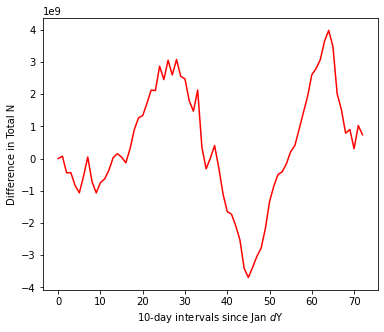

In [14]:
if recalc:
    #plt.plot(SiGlobalTot[sdir0]-SiGlobalTot[sdir0][0],'r-')
    #plt.plot(SiGlobalTot[sdir3]-SiGlobalTot[sdir3][0],'g-')
    #plt.plot(40,test-SiGlobalTot[sdir1][0],'r*')
    #plt.plot(40,test2-SiGlobalTot[sdir1][0],'k*')
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    ax.plot(NGlobalTot[sdir1]-NGlobalTot[sdir1][0],'r-')
    ax.set_xlabel('10-day intervals since '+t0.strftime('%b $d $Y'))
    ax.set_ylabel('Difference in Total N')

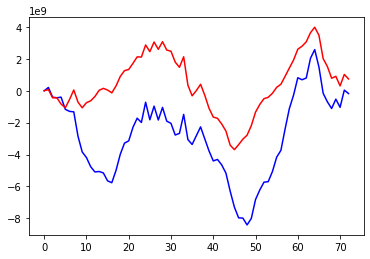

In [15]:
if recalc:
    plt.plot(SiGlobalTot[sdir1]-SiGlobalTot[sdir1][0],'b-')
    plt.plot(NGlobalTot[sdir1]-NGlobalTot[sdir1][0],'r-')

In [18]:
if recalc:
    pickle.dump(SiGlobalTot[sdir1],open('SiGlobalTot_202007F.pkl','wb'))
    pickle.dump(NGlobalTot[sdir1],open('NGlobalTot_202007F.pkl','wb'))

In [19]:
SiGlobalTot7F=pickle.load(open('SiGlobalTot_202007F.pkl','rb'))
NGlobalTot7F=pickle.load(open('NGlobalTot_202007F.pkl','rb'))

In [20]:
SiGlobalTotHC=pickle.load(open('SiGlobalTot_HC1905.pkl','rb'))
NGlobalTotHC=pickle.load(open('NGlobalTot_HC1905.pkl','rb'))

In [21]:
SiGlobalTotHC18=pickle.load(open('SiGlobalTot_HCDec.pkl','rb'))
NGlobalTotHC18=pickle.load(open('NGlobalTot_HCDec.pkl','rb'))

In [22]:
SiGlobalTotHC1=pickle.load(open('SiGlobalTot_HC19spin1.pkl','rb'))
NGlobalTotHC1=pickle.load(open('NGlobalTot_HC19spin1.pkl','rb'))

In [23]:
#SiGlobalTotT3=pickle.load(open('SiGlobalTotT3.pkl','rb'))
#NGlobalTotT3=pickle.load(open('NGlobalTotT3.pkl','rb'))

In [24]:
#SiGlobalTotZ1=pickle.load(open('SiGlobalTotZ1.pkl','rb'))
#NGlobalTotZ1=pickle.load(open('NGlobalTotZ1.pkl','rb'))

In [25]:
#tit='spring2015_Z3'
#SiGlobalTotZ3=pickle.load(open('SiGlobalTot_'+tit+'.pkl','rb'))
#NGlobalTotZ3=pickle.load(open('NGlobalTot_'+tit+'.pkl','rb'))

In [26]:
bdir='/data/eolson/MEOPAR/SS36runs/CedarRuns/'

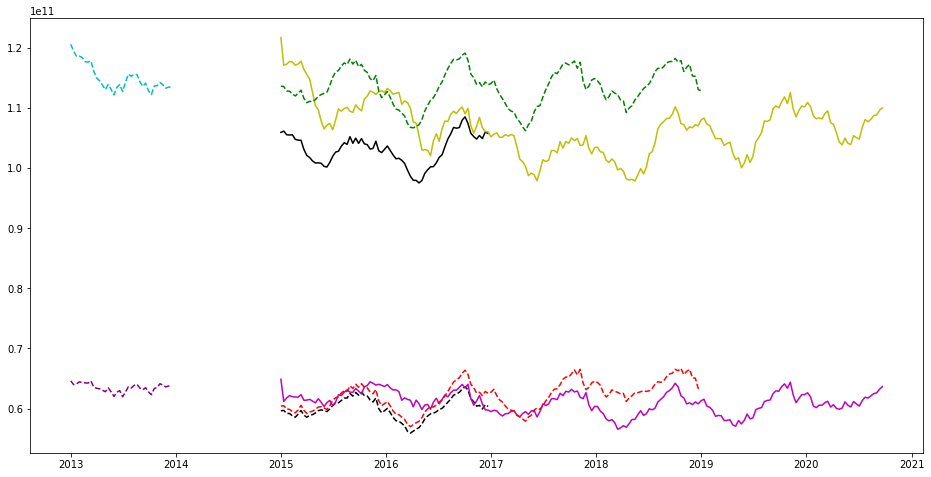

In [27]:
fig,ax=plt.subplots(1,1,figsize=(16,8))
plt.plot([dt.datetime(2015,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTot7F))],SiGlobalTot7F,'k-')
plt.plot([dt.datetime(2015,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTot7F))],NGlobalTot7F,'k--')
plt.plot([dt.datetime(2015,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotHC))],SiGlobalTotHC,'y-')
plt.plot([dt.datetime(2015,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotHC))],NGlobalTotHC,'m-')
plt.plot([dt.datetime(2015,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotHC18))],SiGlobalTotHC18,'g--')
plt.plot([dt.datetime(2015,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotHC18))],NGlobalTotHC18,'r--')
plt.plot([dt.datetime(2013,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotHC1))],SiGlobalTotHC1,'c--')
plt.plot([dt.datetime(2013,1,1)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotHC1))],NGlobalTotHC1,'--',color='purple')
#plt.plot([dt.datetime(2015,1,11)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ4))],SiGlobalTotZ4,'c--')
#plt.plot([dt.datetime(2015,1,11)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ4))],NGlobalTotZ4,'c--')

#ax.plot([dt.datetime(2015,1,11)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ5))],SiGlobalTotZ5,'m:')
#ax.plot([dt.datetime(2015,1,11)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ5))],NGlobalTotZ5,'m:')
#ax.plot([dt.datetime(2015,1,11)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZtest))],SiGlobalTotZtest,'b:')
#ax.plot([dt.datetime(2015,1,11)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZtest))],NGlobalTotZtest,'b:')

#ax.plot([dt.datetime(2016,1,6)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ6))],SiGlobalTotZ6,'r:')
#ax.plot([dt.datetime(2016,1,6)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ6))],NGlobalTotZ6,'r:')
#ax.plot([dt.datetime(2016,1,6)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ7))],SiGlobalTotZ7,'g:')
#ax.plot([dt.datetime(2016,1,6)+dt.timedelta(10*ii) for ii in range(0,len(SiGlobalTotZ7))],NGlobalTotZ7,'g:')